# What's in a Game?

## Introduction

Steam is the largest digital video game distribution service available to Windows, Mac, and Linux users. Today, Steam has a collection of over 60,000 games available to consumers worldwide. Steam users are able to give either a positive or negative review for each of their owned games, and these reviews are able to be seen by other potential customers to help inform their purchasing decision. Logically, we can conclude that games with a higher positive review percentage are regarded as "better" games, in the sense that they are publicly deemed to be worthy of playing. In this tutorial we will analyze various aspects of games on Steam to try and answer the question:

**What makes a game worth playing?**

## Data Collection

First we gather our Steam Web API key a locally stored text document. A key can be requested from [here](https://steamcommunity.com/dev/apikey).

In [1]:
key = open('key.txt').read()

Next we'll import a few key libraries that we will make use of during data collection.

In [2]:
import requests
import pandas as pd
import numpy as np
import time

Steam has a couple of APIs that can be used to find all sorts of information about a game, including pricing information, genre, number of positive reviews, and much more. But to get this information about a game, first you need to know its designated app ID, as given by Steam. Fortunately, there is a third API provided by Steam that can be used to get a list of app IDs for every single app available on the Steam web store. The term "app" includes games, downloadable content (DLCs), software, videos, and hardware. We are only interested in the app IDs for games, so we will set our API request parameters accordingly. Additionally, only 50,000 results are allowed per request, so we will have to make this request multiple times.

In [3]:
all_ids = []
last_appid = 0

while True:
    URL = "https://api.steampowered.com/IStoreService/GetAppList/v1/"
    PARAMS = {"key": key, "max_results": 50000, "include_games": True, "include_dlc": False, "include_software": False, "include_videos": False, "include_hardware": False, "last_appid": last_appid}
    re = requests.get(url=URL, params=PARAMS).json()["response"]
    for app in re["apps"]:
        all_ids.append(app["appid"])
        
    if "last_appid" not in re.keys():
        break
    else:
        last_appid = re["last_appid"]

With the list of app IDs for every game on the Steam store, we can now make calls to the previously mentioned Steam APIs to get information about every game on the Steam web store. First, we will define a list of the categories of information that we will retrieve from the API response for each game. We also create a list of filters that will be sent as a parameter for the API request.

In [4]:
categories = [
    ['name'],
    ['type'],
    ['steam_appid'],
    ['developers'],
    ['publishers'],
    ['is_free'],
    ['price_overview', 'initial'],
    ['achievements', 'total'],
    ['release_date', 'date'],
    ['metacritic', 'score']
]

filters = ''
for cat in categories:
    filters += cat[0] + ','
filters += 'basic,genres,categories'

Next we define a function to extract this information from each response, which relies on the fact that the API responses are in the JSON format.

In [5]:
def fetch(game_info, categories):
    info = {}
    for category in categories:
        cur_info = game_info
        failed = False
        
        for subpart in category:
            if not failed and subpart in cur_info.keys():
                cur_info = cur_info[subpart]
            else:
                failed = True
        
        if not failed:
            info[' '.join(category)] = cur_info
        else:
            info[' '.join(category)] = np.NaN
    
    if 'genres' in game_info.keys():
        for genre in game_info['genres']:
            info['Genre: ' + genre['description']] = True
    if 'categories' in game_info.keys():
        for genre in game_info['categories']:
            info['Category: ' + genre['description']] = True
    
    return info

As previously mentioned, there are two APIs that will be queried to gather all of the desired information. These APIs seem to have a limit of 200 calls for every 5 minutes, so to account for this we will design special functions for both APIs that will wait until the response code 429 ("Too Many Requests") passes.

In [6]:
def store_query(app_id):
    global filters, key
    
    max_attempts = 11
    attempts = 0
    
    URL = f"http://store.steampowered.com/api/appdetails/?appids={app_id}"
    PARAMS = {'filters': filters, 'l': 'en', 'key': key}
    
    while attempts < max_attempts:
        re = requests.get(url=URL, params=PARAMS)

        if re.status_code != 429:
            break
            
        time.sleep(30)
        attempts += 1
        
    if attempts >= max_attempts:
        print(f"ERROR: Store query timeout on {app_id}")
        return None
    else:
        return re
    
def review_query(app_id):
    max_attempts = 11
    attempts = 0
    
    URL = f"http://store.steampowered.com/appreviews/{app_id}?json=1"
    PARAMS = {'num_per_page': 0, 'language': 'all', 'purchase_type': 'all'}
    
    while attempts < max_attempts:
        re = requests.get(url=URL, params=PARAMS)

        if re.status_code != 429:
            break
            
        time.sleep(30)
        attempts += 1
        
    if attempts >= max_attempts:
        print(f"ERROR: Review query timeout on {app_id}")
        return None
    else:
        return re

With all of that out of the way, we are able to collect the data. We wrap the response parsing in a try-except statement because even though all responses are supposed to be in JSON format, if for whatever reason a response cannot be parsed as a JSON we do not want to halt the program from running.

In [7]:
def generate_df(ids):
    all_info = []
    for app_id in ids:
        # make main api query
        re = store_query(app_id)

        try:
            if re is not None and re.json()[str(app_id)]['success']:
                game_info = re.json()[str(app_id)]['data']
                info = fetch(game_info, categories)

                # make review api query
                re = review_query(app_id)
                if re is not None:
                    summary = re.json()
                    if 'query_summary' in summary.keys():
                        q_summary = summary['query_summary']

                        if 'total_positive' in q_summary:
                            info['total_positive'] = q_summary['total_positive']
                        else:
                            info['total_positive'] = np.NaN

                        if 'total_reviews' in q_summary:
                            info['total_reviews'] = q_summary['total_reviews']
                        else:
                            info['total_reviews'] = np.NaN

                # add the gathered information to the list
                all_info.append(info)
        except:
            print(f"ERROR: JSON parsing error on {app_id}")

    df = pd.DataFrame.from_dict(all_info)
    return df

For practicality reasons, we collected the data beforehand in twenty different batches defined by `np.array_split(all_apps, 20)` and stored the dataframe for each batch as a pickle file so that we could easily load it back up without having to regather the data. Once all batches were completed, the data was then combined with `games_df = pd.concat([df0, df1, df2, ... , df19], ignore_index=True, sort=False)`, and the final combined dataframe was stored locally as "games_df.pkl". This was done because the API request limitations mean that data collection took about 29 hours in total.

In [8]:
df = pd.read_pickle("games_df.pkl") # generate_df(all_ids)
df.head()

,name,type,steam_appid,developers,publishers,is_free,price_overview initial,achievements total,release_date date,metacritic score,...,Genre: Web Publishing,Genre: Accounting,Genre: Video Production,Genre: Game Development,Genre: Photo Editing,Genre: Documentary,Genre: Episodic,Genre: Short,Genre: Tutorial,Genre: 360 Video
0,Counter-Strike,game,10,[Valve],[Valve],False,999.0,NaN,"Nov 1, 2000",88.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Team Fortress Classic,game,20,[Valve],[Valve],False,499.0,NaN,"Apr 1, 1999",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Day of Defeat,game,30,[Valve],[Valve],False,499.0,NaN,"May 1, 2003",79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deathmatch Classic,game,40,[Valve],[Valve],False,499.0,NaN,"Jun 1, 2001",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Half-Life: Opposing Force,game,50,[Gearbox Software],[Valve],False,499.0,NaN,"Nov 1, 1999",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Processing

The dataframe now as all the information we want, but not all of it is in the desired format. First we replace NaN values from the genre or category columns with false. Values in the genres column are set to NaN if the app was not tagged as part of that genre/category, so this is a logical replacement value.

In [9]:
for col_name in df:
    if col_name.startswith('Genre: ') or col_name.startswith('Category: '):
        df[col_name].fillna(False, inplace=True)

Next we change the release dates to all be in the same format, the pandas datetime format. The parameter `errors='coerce'` means that if pandas cannot figure out what the date format means, then it will set the value to pd.NaT. This is reasonable because there are many apps and not all will use a recognizable format, but we do not want those few exceptions to bring the process to a complete stop. The parameter `infer_datetime_format=True` is used because there is no consistent date format for all Steam pages. The main reason the release date would not be in a format recognized by pandas would be if the date is given in a language other than English.

In [10]:
df['release_date date'] = pd.to_datetime(df['release_date date'], errors='coerce', infer_datetime_format=True)

Now we define a function to determine positive review percentage for a row. Gives NaN if missing either the total review count or total count of positive reviews.

In [11]:
def positive_perc(row):
    if not np.isnan(row['total_reviews']) and row['total_reviews'] != 0 and not np.isnan(row['total_positive']):
        return row['total_positive'] / row['total_reviews']
    else:
        return np.NaN

With the function defined, we can now add a positive review percentage column to the dataframe.

In [12]:
df['positive_proportion'] = df.apply(positive_perc, axis=1)

We can see that for free games, the price column tends to be NaN. It is reasonable to say that if a game is free, then its price should be 0. We will now define a function to do this for us. The price is intially stored in cents, so we will divide it by 100 to get it in terms of U.S dollars.

In [13]:
def get_price(row):
    if np.isnan(row['price_overview initial']) and row['is_free']:
        return 0
    else:
        return row['price_overview initial'] / 100.0

We apply this function to the price_overview initial column, and rename the column to just price for the sake of brevity.

In [14]:
df['price_overview initial'] = df.apply(get_price, axis=1)
df.rename({'price_overview initial': 'price'}, axis='columns', inplace=True)

If we look at some games with NaN in the achievements total column, we find that these are games which do not have any Steam achievements. Therefore we can reasonable impute the value of 0 instead of NaN, as this will accurately reflect the fact that the game has no achievements.

In [15]:
df['achievements total'].fillna(0, inplace=True)

Now let's get an idea of what the tidied up dataframe looks like

In [16]:
df.head()

,name,type,steam_appid,developers,publishers,is_free,price,achievements total,release_date date,metacritic score,...,Genre: Accounting,Genre: Video Production,Genre: Game Development,Genre: Photo Editing,Genre: Documentary,Genre: Episodic,Genre: Short,Genre: Tutorial,Genre: 360 Video,positive_proportion
0,Counter-Strike,game,10,[Valve],[Valve],False,9.99,0.0,2000-11-01,88.0,...,False,False,False,False,False,False,False,False,False,0.974959
1,Team Fortress Classic,game,20,[Valve],[Valve],False,4.99,0.0,1999-04-01,NaN,...,False,False,False,False,False,False,False,False,False,0.858584
2,Day of Defeat,game,30,[Valve],[Valve],False,4.99,0.0,2003-05-01,79.0,...,False,False,False,False,False,False,False,False,False,0.900992
3,Deathmatch Classic,game,40,[Valve],[Valve],False,4.99,0.0,2001-06-01,NaN,...,False,False,False,False,False,False,False,False,False,0.820000
4,Half-Life: Opposing Force,game,50,[Gearbox Software],[Valve],False,4.99,0.0,1999-11-01,NaN,...,False,False,False,False,False,False,False,False,False,0.952906


## Exploratory Data Analysis

While somewhat arbitrary, for the following data analysis we will only consider games that have 100 or more total reviews. This was done to limit the influence of outliers on our data analysis. Some games on Steam, such as this [one](https://store.steampowered.com/app/1200520/Ascent_FreeRoaming_VR_Experience/), are incredibly expensive, but have very few total reviews. There are other games, such as this [one](https://store.steampowered.com/app/29700/Guild_Wars_Eye_of_the_North/), have 100% positive reviews, but very few total reviews (this example has only one review at the time of writing). For these reasons, we find that 100 reviews is a good minimum value to analyze how various game attributes influence each games positive review proportion.

In [17]:
prop_df = df[df['total_reviews'] >= 100]

<hr />

### Does the timing matter?

Is there some relationship between release date and positive rating percentage? Maybe they just don't make games like they used to, or maybe technological advancements mean that modern games are superior. We'll make a violin plot using matplotlib to compare release year and positive review percentage to try and get some idea.

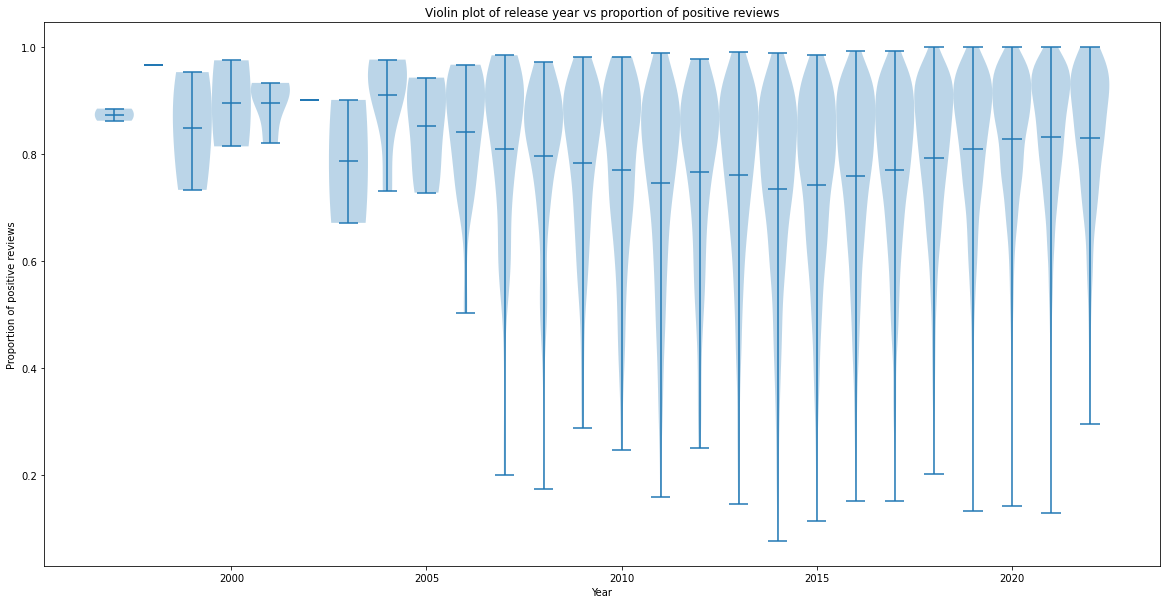

In [18]:
from matplotlib import pyplot as plt

yearly_data = {}
for _, row in prop_df.iterrows():
    if row['release_date date'].year in yearly_data:
        yearly_data[row['release_date date'].year].append(row['positive_proportion'])
    else:
        yearly_data[row['release_date date'].year] = [row['positive_proportion']]

fig, ax = plt.subplots(figsize=(20,10))
ax.violinplot(list(yearly_data.values()), list(yearly_data.keys()), widths=1, showmeans=True)
ax.set_title("Violin plot of release year vs proportion of positive reviews")
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of positive reviews")
pass

There does not appear to be any significant relationship here. Looking at the means we each year, we do not see a strong trend. A linear relationship is doubtful, so we'll check a different factor.

While it seems that release year may be a non-factor, what about release month? Do "better" games tend to release at certain points throughout the year, in an attempt to maximize sales? We will make another violin plot to analyze these distributions.

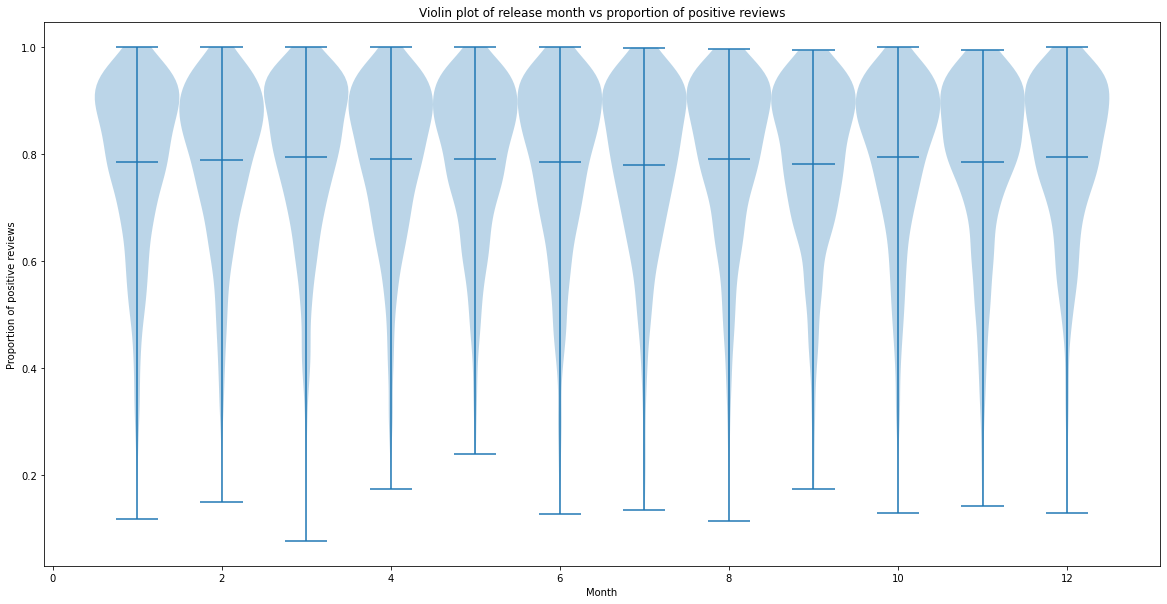

In [19]:
monthly_data = {}
for _, row in prop_df.iterrows():
    if row['release_date date'].month in monthly_data:
        monthly_data[row['release_date date'].month].append(row['positive_proportion'])
    else:
        monthly_data[row['release_date date'].month] = [row['positive_proportion']]

fig, ax = plt.subplots(figsize=(20,10))
ax.violinplot(list(monthly_data.values()), list(monthly_data.keys()), widths=1, showmeans=True)
ax.set_title("Violin plot of release month vs proportion of positive reviews")
ax.set_xlabel("Month")
ax.set_ylabel("Proportion of positive reviews")
pass

These distributions are nearly identical. Each has roughly the same mean, and roughly the same shape. All have a significant negative skew. This tells us that release month probably does not play a signficant role in influencing what the positive review proportion for a game will be.

<hr />

### Does price matter?

Our initial suspicion is that people will are more willing to leave a positive review for a cheaper game. This is because a lower cost of entry should enhance a game's recommendability. However, it may also be the case that some of the "worst" games are sold at a low cost, and customers are still disappointed despite the game being inexpensive. To see if either of these theories have merit, we will create a scatter plot with price on the x-axis and proportion of positive reviews on the y-axis, along with a line of best fit.

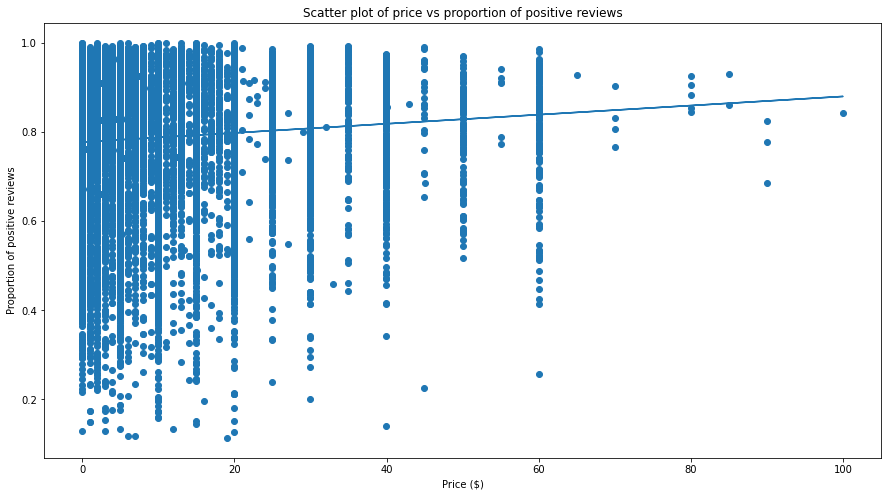

In [20]:
fig, ax = plt.subplots(figsize=(15,8))
prices = prop_df.dropna(subset=['price'])['price']
positive_props = prop_df.dropna(subset=['price'])['positive_proportion']
ax.scatter(prices, positive_props)
ax.set_title("Scatter plot of price vs proportion of positive reviews")
ax.set_xlabel("Price ($)")
ax.set_ylabel("Proportion of positive reviews")
m, b = np.polyfit(prices, positive_props, 1)
ax.plot(prices, m*prices+b)
pass

One can observe the vertical lines of dots at certain locations on the x-axis. These lines represent the most common prices that games tend to be sold, such as 0, 10, 20, and 60 dollars.\
The regression line suggests a positive correllation between price and proportion of positive reviews, but one can see that this relationship is not very strong. The distribution along each price point is far too wide for a simple linear model such as this to have any real-world utility.

<hr />

### Does critical acclaim matter?

The `metacritic score` column in this dataset reflects the game's critic review score as determined by Metacritic. We suspect that the scatter plot will indicate a strong, positive correlation between critic score and positive review proportion. This is because in aggregate, people tend to have similar views when it comes to the quality of something. We will analyze this by making a scatter plot with critic score on the x-axis and positive review proportion on the y-axis.

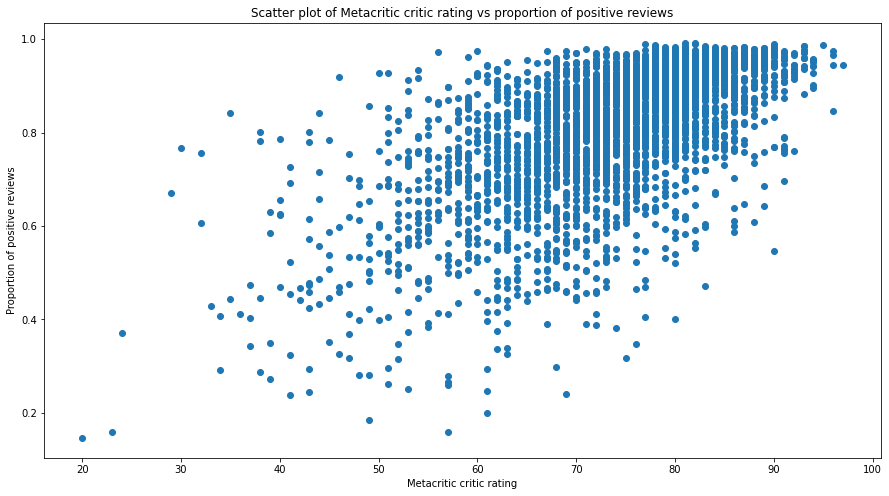

In [21]:
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(prop_df['metacritic score'], prop_df['positive_proportion'])
ax.set_title("Scatter plot of Metacritic critic rating vs proportion of positive reviews")
ax.set_xlabel("Metacritic critic rating")
ax.set_ylabel("Proportion of positive reviews")
pass

As suspected, there does appear to be a strong, positive correlation between critic rating and positive review proportion. However, this will be the extent of our analysis on Metacritic score for a few reasons. First, only a small percentage of Steam games actually have a Metacritic score. Second, this relationship is fairly obvious, and does not provide much in terms of valuable insight.

<hr />

### Does a sense of pride and accomplishment matter?

Does the number of achievements a game has play a role in its proportion of positive reviews? Initial thoughts are that the relationship is weak, but probably slightly positive. The point of an achievement in a video game is to reward the player for some action they have completed, and it is not unreasonable to guess that this feeling of being rewarded would improve a person's opinion of a game. To see if this relationship exists, we will create a scatter plot with number of achievements on the x-axis and proportion of positive reviews on the y-axis.

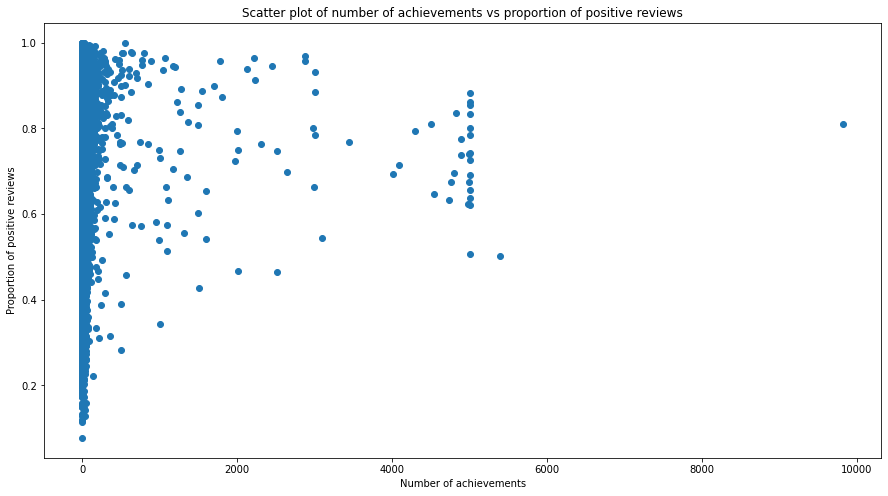

In [22]:
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(prop_df['achievements total'], prop_df['positive_proportion'])
ax.set_title("Scatter plot of number of achievements vs proportion of positive reviews")
ax.set_xlabel("Number of achievements")
ax.set_ylabel("Proportion of positive reviews")
pass

There does seem to be some sort of a relationship here, but it is quite clear that the vast majority of games on Steam have an achievement count of below 1000. While it appears that the minimum proportion of positive reviews increases as achievement count increases, it also seems that the maximum proportion decreases. In reality, this is because the sample size of games with more than 1000 achievements is quite small, so our idea of what their distribution should be is unclear.

Maybe it isn't the number of achievements that matters, but the presense of achievements at all. We will make a bar plot comparing average positive review proportion of games with and without achievements, to get a better idea of if these proportions appear to be significantly different. For this bar graph every game will be weighted equally, so games with more reviews will not have more influence over the average proportion than games with fewer reviews.

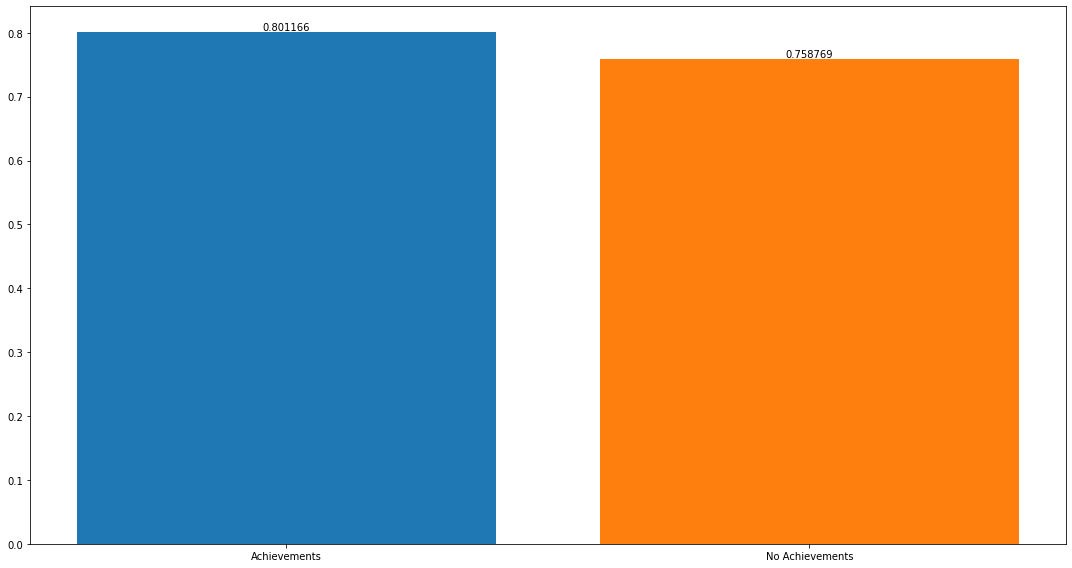

In [23]:
fig, ax = plt.subplots(figsize=(15,8))
ax.bar_label(ax.bar('Achievements', prop_df[prop_df['achievements total'] > 0]['positive_proportion'].mean()))
ax.bar_label(ax.bar('No Achievements', prop_df[prop_df['achievements total'] == 0]['positive_proportion'].mean()))

fig.tight_layout()
pass

It does appear that games with achievements tend to have a higher proportion of positive reviews on average, so the statistical significance of this difference will be tested later.

<hr />

### Which genres are the best?

Bar chart of average positive review proportion for each genre. Definitely going to be a lot of double/triple/more counting, but I think it is probably fine.

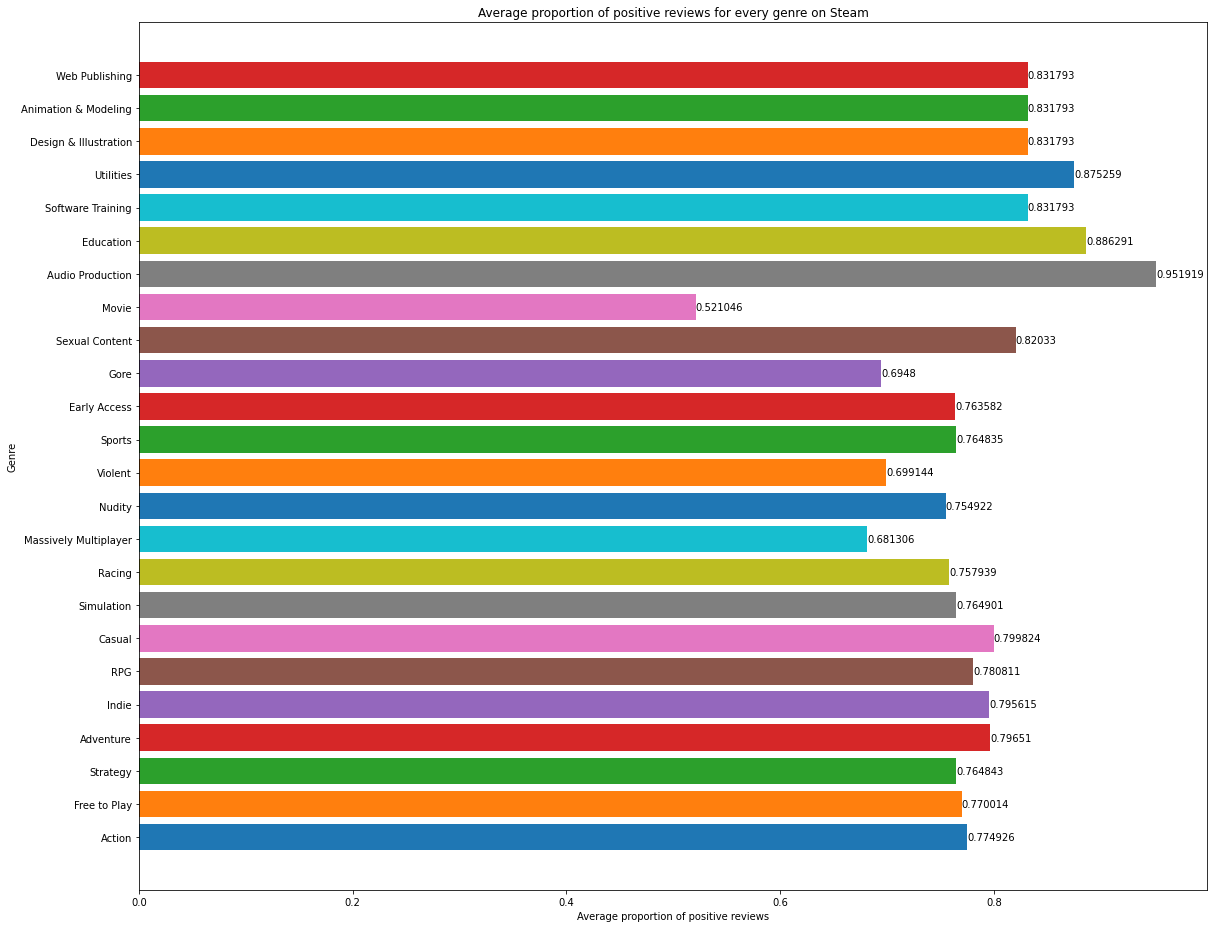

In [24]:
fig, ax = plt.subplots(figsize=(17,13))

for col_name in prop_df:
    if col_name.startswith('Genre: ') and len(prop_df[prop_df[col_name] == True]) > 0:
        ax.bar_label(ax.barh(col_name[len('Genre: '):], prop_df[prop_df[col_name] == True]['positive_proportion'].mean()))
        
ax.set_title("Average proportion of positive reviews for every genre on Steam")
ax.set_xlabel("Average proportion of positive reviews")
ax.set_ylabel("Genre")

fig.tight_layout()
pass

Audio production ahead by a not small amount, movies kinda bad.

<hr />

### Which categories are the best?

Same thing for categories

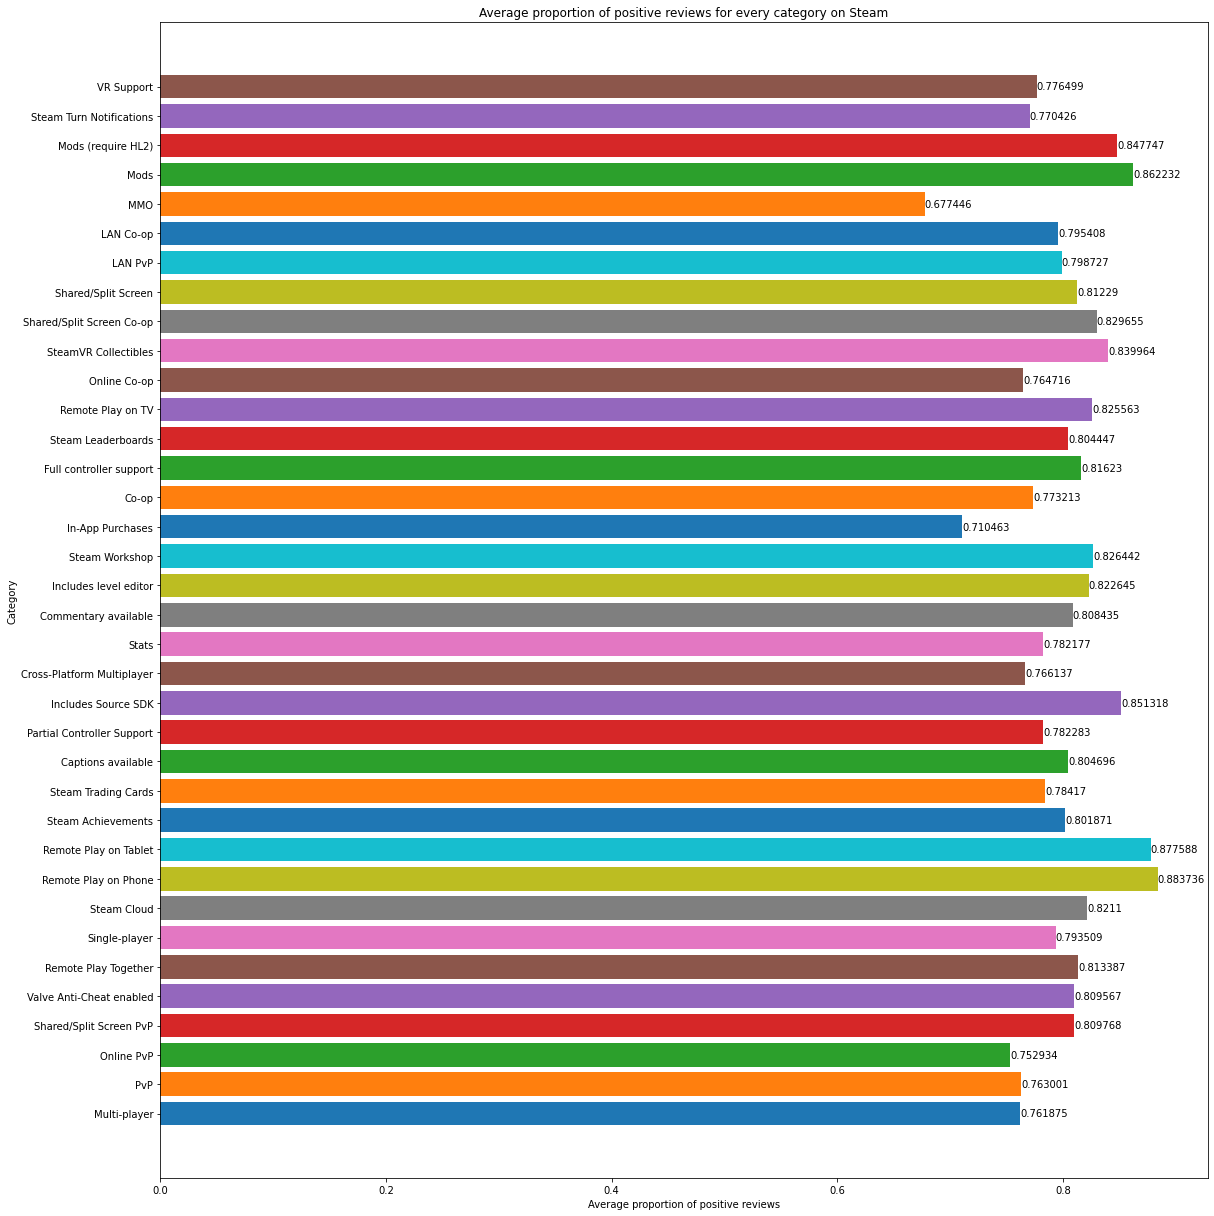

In [25]:
fig, ax = plt.subplots(figsize=(17,17))

for col_name in prop_df:
    if col_name.startswith('Category: ') and len(prop_df[prop_df[col_name] == True]) > 0:
        ax.bar_label(ax.barh(col_name[len('Category: '):], prop_df[prop_df[col_name] == True]['positive_proportion'].mean()))
        
ax.set_title("Average proportion of positive reviews for every category on Steam")
ax.set_xlabel("Average proportion of positive reviews")
ax.set_ylabel("Category")

fig.tight_layout()
pass

MMOs and in-app purchases seem to be the worst, on average

## Analysis & Hypothesis Testing

Do games with achievements have a statistically significantly higher proportion of positive reviews than games without achievements? We will test the following hypothesis:\
$H_0: u_A - u_N = 0$\
$H_1: u_A - u_N > 0$\
Where $u_A$ is the true average proportion of positive reviews for games with achievements, and $u_N$ is the true average proportion of positive reviews for games without achievements\
This hypothesis will be tested at $\alpha = 0.05$, as that is a fairly standard value used by statisticians.

Note: We are not performing a test for difference in population proportions. This is because we are comparing a collective of games against a different collective of games. We do not believe that just because a game has achievements, the probability of getting a positive review is the same as all other games with achievements. This is what would be suggested by a test for difference of population proportions. Rather, we believe that the proportion of positive reviews for games with achievements has some distribution with mean $u_A$, and we want to see if that is significantly diffrent from the mean of the distribution of proportion of positive reviews for games without achievements, $u_N$.

In [26]:
achievements = prop_df[prop_df['achievements total'] > 0]
no_achievements = prop_df[prop_df['achievements total'] == 0]

Now we check the necessary assumptions for a two-sample Z-test:
- $n_A > 40$
- $n_N > 40$

Where $n_A$ is the number of games with achievements and $n_N$ is the number of games without achievements.

By the Central Limit Theorem, $\overline{X_A} - \overline{X_N}$ will have an approximately normal solution when these sample size conditions are met. This means that we do not even have to assume that the distribution of positive review proportions are normal for both games with and without achievements.

In [27]:
n_A = len(achievements)
n_N = len(no_achievements)
print(n_A > 40)
print(n_N > 40)

True
True


With all the assumptions met, we can now calculate the test statistic.\
$z = \dfrac{\overline{x_A} - \overline{x_N}}{\sqrt{\dfrac{{s_A}^2}{n_A}+\dfrac{{s_N}^2}{n_N}}}$

In which $\overline{x_A}$ is the sample mean proportion of positive reviews for games with achievements, $\overline{x_N}$ is the sample mean proportion of positive reviews for games without achievements, $s_A$ is the sample standard deviation of proportions of positive reviews for games with achievements, and $s_N$ is the sample standard deviation of proportions of positive reviews for games with achievements.

In [28]:
x_A = achievements['positive_proportion'].mean()
s_A = achievements['positive_proportion'].std()
x_N = no_achievements['positive_proportion'].mean()
s_N = no_achievements['positive_proportion'].std()

z = (x_A - x_N) / np.sqrt( ((s_A**2) / n_A) + ((s_N**2) / n_N) )
z

15.026486207478625

Now we will find the associated p-value for this test statistic on a right tailed test.

In [29]:
import scipy.stats

p_val = scipy.stats.norm.sf(z)
p_val

2.4622169736204977e-51

With a p-value less than our $\alpha$ of $0.05$, we reject the null hypothesis. There is significant evidence that Steam games with achievements have a higher average proportion of positive reviews than Steam games without achievements.

### Which genres have a significantly higher average proportion of positive reviews than games outside that genre? Time to test all of these hypotheses!

In [52]:
z_alpha = scipy.stats.norm.ppf(0.95)

better_genres = []
worse_genres = []
not_diff_genres = []
not_enough_genres = []

for col_name in prop_df:
    if col_name.startswith('Genre: '):
        in_cat = prop_df[prop_df[col_name] == True]
        out_cat = prop_df[prop_df[col_name] == False]
        n_in = len(in_cat)
        n_out = len(out_cat)
        if n_in > 40 and n_out > 40:
            x_in = in_cat['positive_proportion'].mean()
            s_in = in_cat['positive_proportion'].std()
            x_out = out_cat['positive_proportion'].mean()
            s_out = out_cat['positive_proportion'].std()
            z = (x_in - x_out) / np.sqrt( ((s_in**2) / n_in) + ((s_out**2) / n_out) )
            if z < -z_alpha:
                worse_genres.append(col_name)
            elif z > z_alpha:
                better_genres.append(col_name)
            else:
                not_diff_genres.append(col_name)
        else:
            not_enough_genres.append(col_name)


print('{:<40}{:<40}{:<40}{:<40}'.format('Better', 'Worse', 'Not Different', 'Not Enough Data'))
print('-'*40*4)
for i in range(max(len(better_genres), len(worse_genres), len(not_diff_genres), len(not_enough_genres))):
    first = better_genres[i][len('Genre: '):] if i < len(better_genres) else ""
    second = worse_genres[i][len('Genre: '):] if i < len(worse_genres) else ""
    third = not_diff_genres[i][len('Genre: '):] if i < len(not_diff_genres) else ""
    fourth = not_enough_genres[i][len('Genre: '):] if i < len(not_enough_genres) else ""
    print('{:<40}{:<40}{:<40}{:<40}'.format(first, second, third, fourth))

Better                                  Worse                                   Not Different                           Not Enough Data                         
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Adventure                               Action                                                                          Nudity                                  
Indie                                   Free to Play                                                                    Sexual Content                          
Casual                                  Strategy                                                                        Movie                                   
                                        RPG                                                                             Audio Production                        
                                  

### Which categories have a significantly higher average proportion of positive reviews than games outside that category? Time to test all of these hypotheses!

In [50]:
z_alpha = scipy.stats.norm.ppf(0.95)

better_cats = []
worse_cats = []
not_diff_cats = []
not_enough_cats = []

for col_name in prop_df:
    if col_name.startswith('Category: '):
        in_cat = prop_df[prop_df[col_name] == True]
        out_cat = prop_df[prop_df[col_name] == False]
        n_in = len(in_cat)
        n_out = len(out_cat)
        if n_in > 40 and n_out > 40:
            x_in = in_cat['positive_proportion'].mean()
            s_in = in_cat['positive_proportion'].std()
            x_out = out_cat['positive_proportion'].mean()
            s_out = out_cat['positive_proportion'].std()
            z = (x_in - x_out) / np.sqrt( ((s_in**2) / n_in) + ((s_out**2) / n_out) )
            if z < -z_alpha:
                worse_cats.append(col_name)
            elif z > z_alpha:
                better_cats.append(col_name)
            else:
                not_diff_cats.append(col_name)
        else:
            not_enough_cats.append(col_name)


print('{:<40}{:<40}{:<40}{:<40}'.format('Better', 'Worse', 'Not Different', 'Not Enough Data'))
print('-'*40*4)
for i in range(max(len(better_cats), len(worse_cats), len(not_diff_cats), len(not_enough_cats))):
    first = better_cats[i][len('Category: '):] if i < len(better_cats) else ""
    second = worse_cats[i][len('Category: '):] if i < len(worse_cats) else ""
    third = not_diff_cats[i][len('Category: '):] if i < len(not_diff_cats) else ""
    fourth = not_enough_cats[i][len('Category: '):] if i < len(not_enough_cats) else ""
    print('{:<40}{:<40}{:<40}{:<40}'.format(first, second, third, fourth))

Better                                  Worse                                   Not Different                           Not Enough Data                         
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Shared/Split Screen PvP                 Multi-player                            Stats                                   Includes Source SDK                     
Valve Anti-Cheat enabled                PvP                                     Commentary available                    SteamVR Collectibles                    
Remote Play Together                    Online PvP                              LAN PvP                                 Mods                                    
Single-player                           Steam Trading Cards                     LAN Co-op                               Mods (require HL2)                      
Steam Cloud                       

### Models to predict positive review proportion

I'm not too sure that a linear regression is appropriate for purely categorical values, even with the encoding stuff part of the assumption of the linear model is that there is a linear relationship between the independent and dependent variables, but if the independent variables can only be 0 or 1 I don't know if that really makes sense. Normally you would use a scatter plot or something to check if a linear relationship seems appropriate, but you can't really scatter plot just categorical stuff in a meaningful way. Games aren't marked as "more" of an RPG than other games.

I would say some more appropriate models would be either
- Random Forest/Decision Tree
- K-NN for regression (take the average value of the k nearest neighbors)

#### K-NN (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

Since we identified above that price, achievements, genre, and categories all seem to have some influence over the expected positive review proportion for a game, we will those as our model's attributes. 

NOTE: I suspect that a lot of overfitting is probably going on as a result of too many attributes being used per observation. However, I'm not sure how to best decide which attributes are not worth using.

In [32]:
regression_cats = ['price', 'achievements total']
for col_name in prop_df:
    if col_name.startswith('Genre: ') or col_name.startswith('Category: '):
        regression_cats.append(col_name)


X = prop_df.dropna(subset=['positive_proportion', 'price', 'achievements total'])[regression_cats]
y = prop_df.dropna(subset=['positive_proportion', 'price', 'achievements total'])['positive_proportion']

Do holdout

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

We create the K-NN regressor

In [34]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None).fit(X_train, y_train) # all the defaults

test it

In [35]:
knn.score(X_test, y_test)

-0.006626574578910471

yikes that is bad (yes negative values are possible, but they mean the model really sucks)

#### Random Forest (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

we make it and test it

In [36]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0).fit(X_train, y_train)
forest.score(X_test, y_test)

0.14824379636409457

Not very good, but also not very surprising. There's a lot more to the quality of a game besides the categories and genres it is in.

What features seem to be the most important when predicting positive review proportion?

In [37]:
for thing in sorted(zip(forest.feature_importances_, regression_cats), reverse=True):
    print(f"{thing[1]}")

Category: Steam Cloud
price
achievements total
Genre: Massively Multiplayer
Category: Steam Trading Cards
Category: Remote Play on Tablet
Genre: Strategy
Genre: Simulation
Category: Multi-player
Genre: Action
Category: In-App Purchases
Genre: Indie
Genre: Casual
Category: Single-player
Category: Steam Achievements
Category: Full controller support
Genre: RPG
Category: Partial Controller Support
Genre: Adventure
Genre: Early Access
Category: Shared/Split Screen
Category: Steam Leaderboards
Category: Remote Play Together
Category: Steam Workshop
Category: Co-op
Category: Shared/Split Screen PvP
Category: Includes level editor
Category: Captions available
Genre: Racing
Genre: Free to Play
Category: Stats
Genre: Sports
Category: Commentary available
Genre: Gore
Category: MMO
Category: Cross-Platform Multiplayer
Category: Online PvP
Category: Online Co-op
Category: PvP
Category: Remote Play on Phone
Category: Shared/Split Screen Co-op
Category: VR Support
Category: Remote Play on TV
Genre: 

#### models to predict price (certainly do a better job than predicting review percentage)

In [38]:
regression_cats = []
for col_name in prop_df:
    if col_name != 'Genre: Free to Play' and (col_name.startswith('Genre: ') or col_name.startswith('Category: ')):
        regression_cats.append(col_name)


X = prop_df.dropna(subset=['price'])[regression_cats]
y = prop_df.dropna(subset=['price'])['price']

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [40]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None).fit(X_train, y_train) # all the defaults
knn.score(X_test, y_test)

0.2762423436734016

In [41]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=0).fit(X_train, y_train)
forest.score(X_test, y_test)

0.3456434855579906

In [42]:
for thing in sorted(zip(forest.feature_importances_, regression_cats), reverse=True):
    print(f"{thing[1]}")

Genre: Indie
Category: Steam Cloud
Genre: Casual
Category: Full controller support
Category: Steam Achievements
Category: In-App Purchases
Genre: Simulation
Genre: Strategy
Category: Steam Workshop
Category: Partial Controller Support
Genre: Massively Multiplayer
Category: Remote Play on Tablet
Category: Remote Play on TV
Genre: RPG
Category: Single-player
Category: Steam Trading Cards
Genre: Early Access
Genre: Adventure
Category: Online PvP
Category: Steam Leaderboards
Category: LAN PvP
Category: Remote Play Together
Genre: Sports
Category: Co-op
Genre: Action
Category: Includes level editor
Category: Shared/Split Screen Co-op
Category: Online Co-op
Category: LAN Co-op
Category: Valve Anti-Cheat enabled
Category: Stats
Category: Shared/Split Screen
Category: Multi-player
Category: Remote Play on Phone
Category: Cross-Platform Multiplayer
Genre: Racing
Category: PvP
Category: Shared/Split Screen PvP
Category: Captions available
Category: MMO
Category: Commentary available
Category: St

## Insight & Policy Decision

This is not to say that a game in a certain genre cannot be successful, or that making a game in a different genre will guarantee that it is recieved well. There are often no shortcuts to success, but instead these are just general trends we have identified that could be conflated with many other factors. To illustrate this, we'll take a look at two specific games.

- [Cyanide & Happiness - Freakpocalypse (Episode 1)](https://store.steampowered.com/app/869880/Cyanide__Happiness__Freakpocalypse_Episode_1/): Here we have an indie, adventure, casual game that is single-player, has Steam Cloud support, achievements, full controller support, and it has captions. All of these groups have average proportions of positive reviews significantly higher than that of games outside of that group. So surely this game will have a pretty decent positive review percentage. Well, this game actually has only 57.4% positive reviews.

- [狂神无双](https://store.steampowered.com/app/1758450/_/): This is an action, MMO, role-playing game (RPG) with multiplayer, PvP, online PvP, in-app purchases, co-op, and online co-op. Each of these groups have an average proportion of positive reviews that is significnatly lower than that of games outside of that group. So the reviews for this game must be bad, right? Wrong. This game has 94.1% positive reviews.

This also doesn't mean that our data analysis was meaningless. It is not unreasonable to expect that a game that is in well-received genres and has highly regarded features will have good reviews. This is what was demonstrated by our hypothesis tests. As evidence, we can see:

- [The Henry Stickmin Collection](https://store.steampowered.com/app/1089980/The_Henry_Stickmin_Collection/): This is an indie, adventure, casual game that is single-player, allows remote play on both phone and tablet, has achievements, and captions are available. All of these groups have average proportions of positive reviews significantly higher than that of games outside of that group. The natural assumption that this game will therefore have good reviews is correct in this case. The game has a staggering 98.7% positive reviews with over 29,000 total reviews.

- [Wheel Riders Online OBT](https://store.steampowered.com/app/734550/Wheel_Riders_Online_OBT/): This is a free-to-play, action, racing, massively multiplayer game with PvP, online PvP, has Steam trading cards, partial controller support, in-app purchases, co-op, and online co-op. Individually, these groups all have signficantly worse average reviews than games outside the group. If you suspect this means Wheel Riders Online OBT has bad reviews, you would be right. This game has a mere 25.8% positive reviews.

**So should I be making casual indie adventure games or not?**

Probably not unless that is the type of game you want to make. Sure, the statistics indicate that your game will have a higher proportion of positive reviews, but that is an imperfect measure of success.

If maximizing revenue is the goal (as it often is) then perhaps it would be worth sacrificing some review percentage by implementing in-app purchases, for example. Good reviews tend to attract more customers, but only to a certain extent. A notable example is [PUBG: BATTLEGROUNDS](https://store.steampowered.com/app/578080/PUBG_BATTLEGROUNDS/), which reportedly made [$333.6 million in revenue in 2021](https://www.gamespot.com/articles/pubg-revenue-numbers-show-how-much-bigger-pubg-mobile-is-than-console-pc/1100-6500561/). However, the game only has 56.1% positive reviews on Steam.

If the goal is to make a game that you think sounds fun, then you should try it. A highly successful example of this is Sid Meier's Civilization series ([III](https://store.steampowered.com/app/3910/Sid_Meiers_Civilization_III_Complete/), [IV](https://store.steampowered.com/app/3900/Sid_Meiers_Civilization_IV/), [V](https://store.steampowered.com/app/8930/Sid_Meiers_Civilization_V/), and [VI](https://store.steampowered.com/app/289070/Sid_Meiers_Civilization_VI/) are on Steam). In [an interview with CNN](https://www.cnn.com/2012/01/23/tech/gaming-gadgets/sid-meier-civilization/index.html), lead designer Sid Meier said:
> I wanted to make a game that was fun to play. Where it is today, I wouldn’t have dreamed. We made the first "Civilization" game because it was a game that we wanted to play and hoped that if we liked it, others would, too. Lucky for us, people latched on to the game and our fan community has made the game what it is now.

On Steam, Civilizations III, IV, V, and VI have positive review percentages of 88.9%, 92.7%, 96.1%, and 83.5% respectively. Games from this series have been played by hundreds of thousands of people.

**In conclusion,** it would be easy to lose motivation when developing a game whose entire purpose is to be in as many of the "better" genres and categories as possible. If you want to play the statistics game and maximize the number of "better" categories, be sure that what you are making still interests you.

A few features which we found get better reviews on average that can be added to almost every type of Steam game include:
- Achievements
- Steam Cloud support
- Remote play on TV
- Captions

If you have the time and ability, we recommend implementing some or all of these features, as they should not drastically alter the vision behind your game.

If the game you want to make incorporates some of the "worse" genres or categories, do not be dissuaded. There are games in every genre that have found enormous success, and behind each of them is a group of talented and passionate developers.

DELETE THIS EVENTUALLY: below is the code for how I found these games

In [111]:
best_name = ""
best_prop = 0.85
worst_name = ""
worst_prop = 0.7

for _, row in prop_df.iterrows():
    good_cats_in = 0
    bad_cats_in = 0
    for thing in better_genres + better_cats:
        if row[thing]:
            good_cats_in += 1
    for thing in worse_genres + worse_cats:
        if row[thing]:
            bad_cats_in += 1
            
            
    if bad_cats_in >= 10 and good_cats_in <= 0:
        prop = row['positive_proportion']
        if prop > best_prop:
            best_prop = prop
            best_name = row['name']
        elif prop < worst_prop:
            worst_prop = prop
            worst_name = row['name']
        

print(best_name)
print(worst_name)

狂神无双
Wheel Riders Online OBT


In [142]:
#t = prop_df[prop_df['name'] == "Sid Meier’s Civilization® VI"]
t = prop_df[prop_df['steam_appid'] == 289070]
for c in t:
    if c.startswith('Category: ') or c.startswith('Genre: '):
        if t[c].bool():
            print(c)

print(float(t['positive_proportion']))
print(float(t['total_reviews']))

Category: Multi-player
Category: PvP
Category: Online PvP
Category: Shared/Split Screen PvP
Category: Remote Play Together
Category: Single-player
Category: Remote Play on Tablet
Category: Steam Achievements
Category: Steam Trading Cards
Category: Cross-Platform Multiplayer
Category: Steam Workshop
Genre: Strategy
Category: Shared/Split Screen
Category: LAN PvP
Category: Steam Turn Notifications
0.8349230740400652
213452.0


In [130]:
stuff_df = df[df['total_reviews'] >= 500000]
len(stuff_df)

16

In [133]:
worst_name = ""
worst_prop = 1

for _, row in stuff_df.iterrows():
    prop = row['positive_proportion']

    if prop < worst_prop:
        worst_prop = prop
        worst_name = row['name']
        

print(worst_name)

PUBG: BATTLEGROUNDS
